In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [25]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [26]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [27]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [28]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout, activation_fn =nn.Sigmoid() )
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
    

        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [29]:
#models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
models = {'bn': Net(True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [30]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [31]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [32]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.325844
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 2.072166
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.689147
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.438069
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 1.152620
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.982232
Test set:
bn: Loss: 0.9147	Accuracy: 8876.0/10000 (89%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.923791
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.754031
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.675934
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.592338
Train Epoch: 2 [40000/50000 (80%)]	Losses bn: 0.379497
Train Epoch: 2 [50000/50000 (100%)]	Losses bn: 0.365039
Test set:
bn: Loss: 0.4257	Accuracy: 9346.0/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Losses bn: 0.441399
Train Epoch: 3 [10000/50000 (20%)]	Losses bn: 0.269870
Train Epoch: 3 [20000/50000 (40%)]	Losses bn: 0.360647
Train Epoch: 3 [30000/50000 (60%)]	Losses bn: 0.373415
Train Epoch: 3 [400

Train Epoch: 22 [20000/50000 (40%)]	Losses bn: 0.049012
Train Epoch: 22 [30000/50000 (60%)]	Losses bn: 0.016116
Train Epoch: 22 [40000/50000 (80%)]	Losses bn: 0.078235
Train Epoch: 22 [50000/50000 (100%)]	Losses bn: 0.035165
Test set:
bn: Loss: 0.0466	Accuracy: 9864.0/10000 (99%)

Train Epoch: 23 [0/50000 (0%)]	Losses bn: 0.016651
Train Epoch: 23 [10000/50000 (20%)]	Losses bn: 0.014148
Train Epoch: 23 [20000/50000 (40%)]	Losses bn: 0.029020
Train Epoch: 23 [30000/50000 (60%)]	Losses bn: 0.163761
Train Epoch: 23 [40000/50000 (80%)]	Losses bn: 0.020841
Train Epoch: 23 [50000/50000 (100%)]	Losses bn: 0.041690
Test set:
bn: Loss: 0.0475	Accuracy: 9857.0/10000 (99%)

Train Epoch: 24 [0/50000 (0%)]	Losses bn: 0.011714
Train Epoch: 24 [10000/50000 (20%)]	Losses bn: 0.014409
Train Epoch: 24 [20000/50000 (40%)]	Losses bn: 0.034065
Train Epoch: 24 [30000/50000 (60%)]	Losses bn: 0.012165
Train Epoch: 24 [40000/50000 (80%)]	Losses bn: 0.015163
Train Epoch: 24 [50000/50000 (100%)]	Losses bn: 0.0156

Train Epoch: 43 [30000/50000 (60%)]	Losses bn: 0.003327
Train Epoch: 43 [40000/50000 (80%)]	Losses bn: 0.003974
Train Epoch: 43 [50000/50000 (100%)]	Losses bn: 0.008168
Test set:
bn: Loss: 0.0400	Accuracy: 9875.0/10000 (99%)

Train Epoch: 44 [0/50000 (0%)]	Losses bn: 0.006761
Train Epoch: 44 [10000/50000 (20%)]	Losses bn: 0.005753
Train Epoch: 44 [20000/50000 (40%)]	Losses bn: 0.015494
Train Epoch: 44 [30000/50000 (60%)]	Losses bn: 0.025555
Train Epoch: 44 [40000/50000 (80%)]	Losses bn: 0.032356
Train Epoch: 44 [50000/50000 (100%)]	Losses bn: 0.024342
Test set:
bn: Loss: 0.0393	Accuracy: 9866.0/10000 (99%)

Train Epoch: 45 [0/50000 (0%)]	Losses bn: 0.016812
Train Epoch: 45 [10000/50000 (20%)]	Losses bn: 0.004915
Train Epoch: 45 [20000/50000 (40%)]	Losses bn: 0.045035
Train Epoch: 45 [30000/50000 (60%)]	Losses bn: 0.011507
Train Epoch: 45 [40000/50000 (80%)]	Losses bn: 0.003290
Train Epoch: 45 [50000/50000 (100%)]	Losses bn: 0.003456
Test set:
bn: Loss: 0.0393	Accuracy: 9869.0/10000 (99

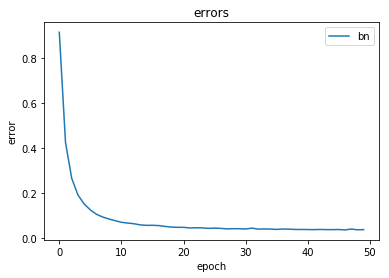

In [33]:
plot_graphs(test_log, 'loss')

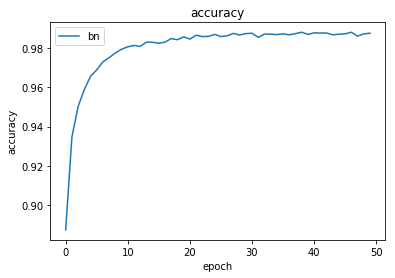

In [34]:
plot_graphs(test_log, 'accuracy')

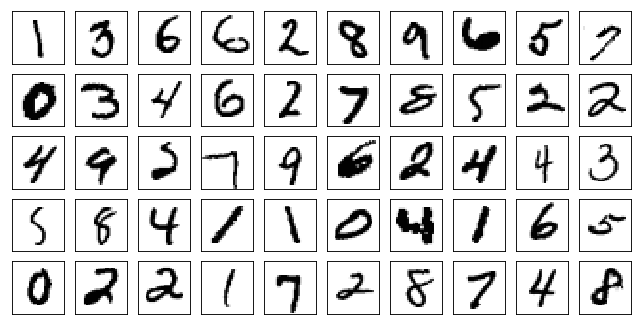

tensor([-6.9518,  5.2943, -6.2082, -7.3083, -1.3481, -4.4462, -7.4913, -2.7133,
        -2.5083, -5.3472], grad_fn=<SelectBackward>)


In [35]:
data, label = next(iter(train_loader))
plot_mnist(data.data.numpy(), (5, 10))
output = models['bn'](data)
output.size()
print(output[0])
#to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
#plot_mnist(to_plot, (5, 10))

### Подгонка картинки или Сделать оптимизацию изображения под активацию сверточных нейронов классификатора

In [36]:
path='./MNIST_data'
from torch.utils.data import DataLoader
train_dataset = torchvision.datasets.MNIST(root = path, train=True, transform=mnist_transform, download=True) 
train_loader_1 = DataLoader(dataset=train_dataset, batch_size=1,shuffle=True) 
data_1_load, label_1 = next(iter(train_loader_1))

In [37]:
# Целевой пусть будет циферка :
target = torch.tensor([3])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


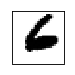

10.350896835327148


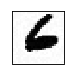

5.64421272277832


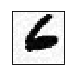

3.0047707557678223


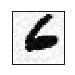

1.1094999313354492


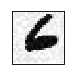

0.3033146858215332


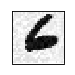

0.11459088325500488


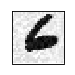

0.03261232376098633


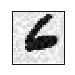

0.0108642578125


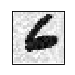

0.003795623779296875


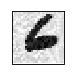

0.0013399124145507812


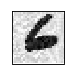

0.0006952285766601562


KeyboardInterrupt: 

In [42]:
# Test
# Cross entropy with OPTIM.zero_grad()
#lr = 0.03
output_ar = []
loss_arr = []
grads = []
data_1 = torch.tensor( data_1_load , requires_grad= True )
opt = optim.Adam([data_1])
#data_1 = data_1_load.detach()
#print(data_1.data)
for i in range(0,200000):
    opt.zero_grad()
    output_1 = model(data_1)
    loss_t = F.cross_entropy(output_1, target)
    loss_t.backward()
    opt = optim.Adam([data_1])
    opt.step()
    if i % 50 == 0:
        plot_mnist(data_1.data.numpy(), (5, 10))
        print(loss_t.data.item())
plot_mnist(data_1.data.numpy(), (5, 10))

In [40]:
#opt.state

In [43]:
# Проверка, что это все таки та цифра, которую ожидали :)
output_1 = model(data_1)
print(output_1)

tensor([[-16.9569,  -1.1730,  -3.0414,   7.7457,  -2.5525,  -0.7616,  -3.3143,
          -1.2299, -21.0487, -13.9153]], grad_fn=<AddmmBackward>)
